# Predicting Who Survived: CPSC 4300/6300-001 Applied Data Science (Fall 2020) Final Project

Using a dataset from Kaggle about the Titanic, we will be attempting to predict which groups were more likely to survive by trainig a model

In [1]:
Team_Members = "Joshua Lin"
# Many ideas and inspirations were from reviewing many of the solutions from https://www.kaggle.com/c/titanic/notebooks
# Most of the code here was reused from the projects we created for this class.

# Importing Related Python Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from collections import defaultdict

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Getting Data
The training and testing set were already provied by Kaggle at https://www.kaggle.com/c/titanic/data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploring Data

We will expore the data to find which areas we need to cleaned.

As stated in https://www.kaggle.com/c/titanic/data, for survived 0 = No and 1 = Yes, pclass represents ticket class of 1 = 1st, 2 = 2nd, 3 = 3rd, sibSp represents # of siblings / spouses aboard the Titanic, parch represents # of parents / children aboard the Titanic, ticket is the ticket number, and embarked represents from where they got on to the Titanic where C = Cherbourg, Q = Queenstown, S = Southampton

In [4]:
# Exploring data
train
train.info()
train.describe()
train.describe(include=['O'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Foo, Mr. Choong",male,CA. 2343,G6,S
freq,1,577,7,4,644


As we can see above, the numerical columns are age, fare, sibSp, parch. The categorical columns are survived, sex, and embarked. The ordinal columns are Pclass. Tickets seemed to be numbers and letters combined together and there are a total of 891 passengers. Most passengers did not travel with any parents / children while about 25% of passnegers had siblings / spouses on board. Everyone had a unique name. A couple of people had the same ticket number. Almost half of the people were living together with someone else in a cabin. Finally, Cabin, age, and embarked seem to be missing some values with cabin missing almost 3/4 of its values.

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


As we can see, fare is also missing one value for test

# Cleaning Data

In this section, we will be cleaning the data by changing all categorical data into numerical, filling in missing data, combine similar data, and removing data that will not be useful.

First will be to remove data that will not be helpful.

We can see that ticket and passengerId will most likely be unhelpful since they are unique to everyone.
In addition, the cabin column will be dropped due to the majority of its value being missing.

In [6]:
train.drop(['PassengerId','Cabin', 'Ticket'], axis=1, inplace = True)
test.drop(['PassengerId','Cabin', 'Ticket'], axis=1, inplace = True)

datasets = [train, test]

For the missing values, we can see that age has as most of them missing while embarked only as a few missing. To replace the missing age values, we will use the median age. To replace the missing embarked values, we will use the most often embarked value. Lastly, to replace the missing fare values, we will use the median fare

In [7]:
for data in datasets:
    #Replacing missing age values
    data['Age'].fillna(data['Age'].median(), inplace = True)

    #Replacing missing embarked values
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)
    
    #Replacing missing fare values
    data['Fare'].fillna(data['Fare'].median(), inplace = True)

Next, we will change sex and embarked data into numerical

In [8]:
for data in datasets:
    data['Sex'] = data['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

Since SibSP and Parch are similar values and meaning and are usually 0, we can combine them into a column called family members on board for better results in our model. The + 1 accounts for the current passenger since he is also apart of his family. We can also create another column based off of family members called alone where 0 = not alone and 1 = alone.

In [9]:
for data in datasets:
    data['Family_Members_On_Board'] = data['SibSp'] + data['Parch'] + 1
    data['Alone'] = 0
    data.loc[data['Family_Members_On_Board'] == 1, 'Alone'] = 1

Next, we will create bins for both fare and age and examine each of the unique bins.

In [10]:
for data in datasets:
    # With age, we will want to use cut so that it will create bins based on the ages themselves
    data['Bin_Of_Age'] = pd.cut(data['Age'].astype(int), 5)

    # For fare, we will want to use qcut so that it will seperate the data into a similar amount in each bin
    data['Bin_Of_Fare'] = pd.qcut(data['Fare'].astype(int), 4)

# Examining each of the unique bins for both age and fare
train.Bin_Of_Age.unique()
train.Bin_Of_Fare.unique()

[(16.0, 32.0], (32.0, 48.0], (48.0, 64.0], (-0.08, 16.0], (64.0, 80.0]]
Categories (5, interval[float64]): [(-0.08, 16.0] < (16.0, 32.0] < (32.0, 48.0] < (48.0, 64.0] < (64.0, 80.0]]

[(-0.001, 7.0], (31.0, 512.0], (7.0, 14.0], (14.0, 31.0]]
Categories (4, interval[float64]): [(-0.001, 7.0] < (7.0, 14.0] < (14.0, 31.0] < (31.0, 512.0]]

After, we will replace each age and fare with a number based on which bin they are in. We will also drop both of the bins once we are done using them.

In [11]:
# Replacing age and fare with number based on bin
for data in datasets:    
    data.loc[ data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age'] = 4
    data['Age'] = data['Age'].astype(int)
    
    data.loc[ data['Fare'] <= 7, 'Fare'] = 0
    data.loc[(data['Fare'] > 7) & (data['Fare'] <= 14), 'Fare'] = 1
    data.loc[(data['Fare'] > 14) & (data['Fare'] <= 31), 'Fare']   = 2
    data.loc[ data['Fare'] > 31, 'Fare'] = 3
    data['Fare'] = data['Fare'].astype(int)
    
    # Dropping bins for age and fare
    data.drop(['Bin_Of_Age', 'Bin_Of_Fare'], axis=1, inplace = True)

Finally, we need to change the name column. If you notice, every name has a correspending title such as Mr, Miss, Rev etc. We will instead extract those as the name for everyone and then change them into a numerical data type based off of their titles.

In [12]:
for data in datasets:
    # Extracting the titles by using split between "," and "." since every title is between a LastName, Title. RestOfName
    data['Name'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    # Extracting all the titles that are used over 10 times into a series
    titles = (data['Name'].value_counts() < 10)
    # Renaming all the rarely used titles Rare_Title since having too many outliers wouldn't be optimal for our model
    data['Name'] = data['Name'].apply(lambda x: 'Rare_Title' if titles.loc[x] == True else x)

We also need to examine all the unique titles and map a number to each title.

In [13]:
train.Name.unique()
numeric_title = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare_Title": 5}
for data in datasets:
    data['Name'] = data['Name'].map(numeric_title)

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare_Title'], dtype=object)

# Modeling

We will now build several models to compare and see which one has the highest accuracy. The models we will be testing are: RandomForestClassifier, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, AdaBoostClassifier, LogisticRegression, and SVC

We will start by training the data. The test data is already provided to us so all we have to do is split the train data.

In [14]:
# Training data
X_train = train.drop("Survived", axis=1)
y_train = train["Survived"]
X_test = test

Next we will build our models while saving each prediction and score

In [21]:
models = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators = 100),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors = 3),
    'GaussianNB': GaussianNB(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC()
}

# Each dict will contain all of what it is suppose to store for each model
all_y_pred = defaultdict(dict)
all_accuracy = defaultdict(dict)
all_models = defaultdict(dict)

# Iterating over all models
for label, model in models.items():
    model = model.fit(X_train, y_train)
    all_models[label] = model
    all_y_pred[label] = model.predict(X_test)
    all_accuracy[label] = round(model.score(X_train, y_train) * 100, 2)

We can see that the two best models in terms of accuracy are the RandomForestClassifier and the DecisionTressClassifier. 

In [22]:
df_final = pd.DataFrame(all_accuracy.values(), all_accuracy.keys()).rename(columns={0: "Accuracy"}).sort_values(by=['Accuracy'],ascending=False)
df_final

,Accuracy
RandomForestClassifier,88.78
DecisionTreeClassifier,88.78
KNeighborsClassifier,85.30
SVC,83.61
AdaBoostClassifier,82.15
LogisticRegression,81.03
GaussianNB,79.69


For our last step, we will find out which features were the most important for determining who survives

In [23]:
# Obtaining all the feature importance percentages
RandomForestClassifier_model = all_models.get("RandomForestClassifier")
importances = RandomForestClassifier_model.feature_importances_

# Getting all the column names except for the Survived
column_names = list(train.columns)
column_names.remove("Survived")

# Making a dict out of column name and their feature importance percentages
feature_importance = defaultdict(dict)
for f in range(len(column_names)):
    feature_importance[column_names[f]] = importances[f]

# Turing the dict into a dataframe so we can view the data
final_importance = pd.DataFrame(feature_importance.values(), feature_importance.keys()).rename(columns={0: "Feature Importance"}).sort_values(by=['Feature Importance'],ascending=False)
final_importance

,Feature Importance
Name,0.268968
Sex,0.181383
Pclass,0.140127
Age,0.092699
Fare,0.091704
Family_Members_On_Board,0.078564
Embarked,0.055715
SibSp,0.045075
Parch,0.031342
Alone,0.014423


Finally we can see that the Name (Title), Sex, and Pclass primarily determined the people who survived while none of the individual family memebers on board made much of a difference (Alone, Parch, SibSp) along with where they embarked from.

<Figure size 432x288 with 0 Axes>

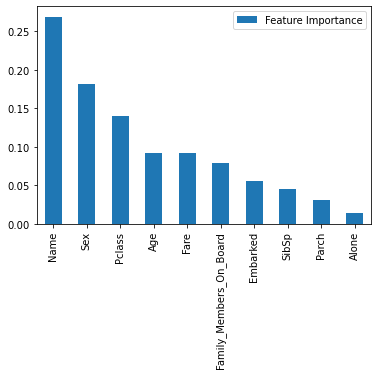

In [24]:
plt.figure();
final_importance.plot(kind='bar');